In [1]:
# pip install tensorflow-gpu==2.0.0-alpha0

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns 
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style = "whitegrid", palette = "muted") #front_scale = 1.5 
rcParams['figure.figsize'] = 28, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
#IMPORTANT NOTES:
#We will fetch data from Binance.com the largest crypto exchanges where one can trade crypto on the spot and futures markets
#The earliest data we can extract from Binance is from August 2017.

In [4]:
from datetime import datetime
from pandas_datareader.data import DataReader

In [5]:
# Data retrieval for cryptocurrencies BTCUSDT ETHUSDT XMRUSDT 
# Binance API credentials 
apikey = '2ZaEiNukiFtPHqnYdCGMANNimHdcCF0nvv4L9eYXMIdr4ovveQrca4NWKsZ7DxAy'
secretkey = '9zjousoyG0t2wblcGkm0tVGLBfz6Woo3paakGh49Vhj0IxrGGXl332b1KQaxlJKY'

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
#API Initialization 
client = Client(apikey, secretkey)

In [6]:
#First attempt with 5 min between May 15 and Dec 1 2021

In [24]:
#Data collection: BTCUSDT 

klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, "15 May, 2021", "1 Dec, 2021")

# for candle in klines:
#   print(candle)

hist_df = pd.DataFrame(klines)
hist_df.columns = (['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume','Nb of Trade', 'TakerBuyBaseVolume', 'TakerBuyQuoteVolume','Ignored'])
# hist_df.drop(labels = ['TakerBuyBaseVolume', 'TakerBuyQuoteVolume', 'Ignored', 'Quote Asset Volume'], inplace = True,axis = 1)
# hist_df['Close Time'] = pd.to_datetime(hist_df['Close Time']/1000, unit='s')
# hist_df['Open Time'] = pd.to_datetime(hist_df['Open Time']/1000, unit='s')
hist_df.drop(['Ignored', 'TakerBuyBaseVolume', 'TakerBuyQuoteVolume', 'Quote Asset Volume'], inplace= True, axis = 1)
hist_df.to_csv('BTCUSDT')
hist_df


,Open Time,Open,High,Low,Close,Volume,Close Time,Nb of Trade
0,1621036800000,49844.16000000,50320.24000000,49269.78000000,49444.70000000,3240.05483700,1621040399999,100780
1,1621040400000,49444.70000000,50700.00000000,49350.50000000,50619.19000000,2899.09590400,1621043999999,79355
2,1621044000000,50619.18000000,50650.73000000,50020.00000000,50084.84000000,2143.71497700,1621047599999,63742
3,1621047600000,50084.83000000,50084.83000000,49601.00000000,49627.01000000,2247.57774000,1621051199999,64393
4,1621051200000,49627.02000000,49861.20000000,49150.92000000,49322.03000000,2921.96110400,1621054799999,77099
...,...,...,...,...,...,...,...,...
4790,1638302400000,57629.99000000,57754.63000000,57193.17000000,57400.41000000,1104.11329000,1638305999999,44314
4791,1638306000000,57400.41000000,57786.08000000,56850.00000000,57097.79000000,1452.77571000,1638309599999,47424
4792,1638309600000,57097.80000000,57534.54000000,57000.78000000,57267.91000000,723.32185000,1638313199999,34411
4793,1638313200000,57267.90000000,57424.23000000,56762.39000000,56950.56000000,1104.34335000,1638316799999,39636


In [26]:
#Convert all the dataframe into numeric 
hist_df = hist_df.apply(pd.to_numeric)
hist_df

#Know the various data types
hist_df.dtypes

Open Time        int64
Open           float64
High           float64
Low            float64
Close          float64
Volume         float64
Close Time       int64
Nb of Trade      int64
dtype: object

Text(0, 0.5, 'Close Price USDT')

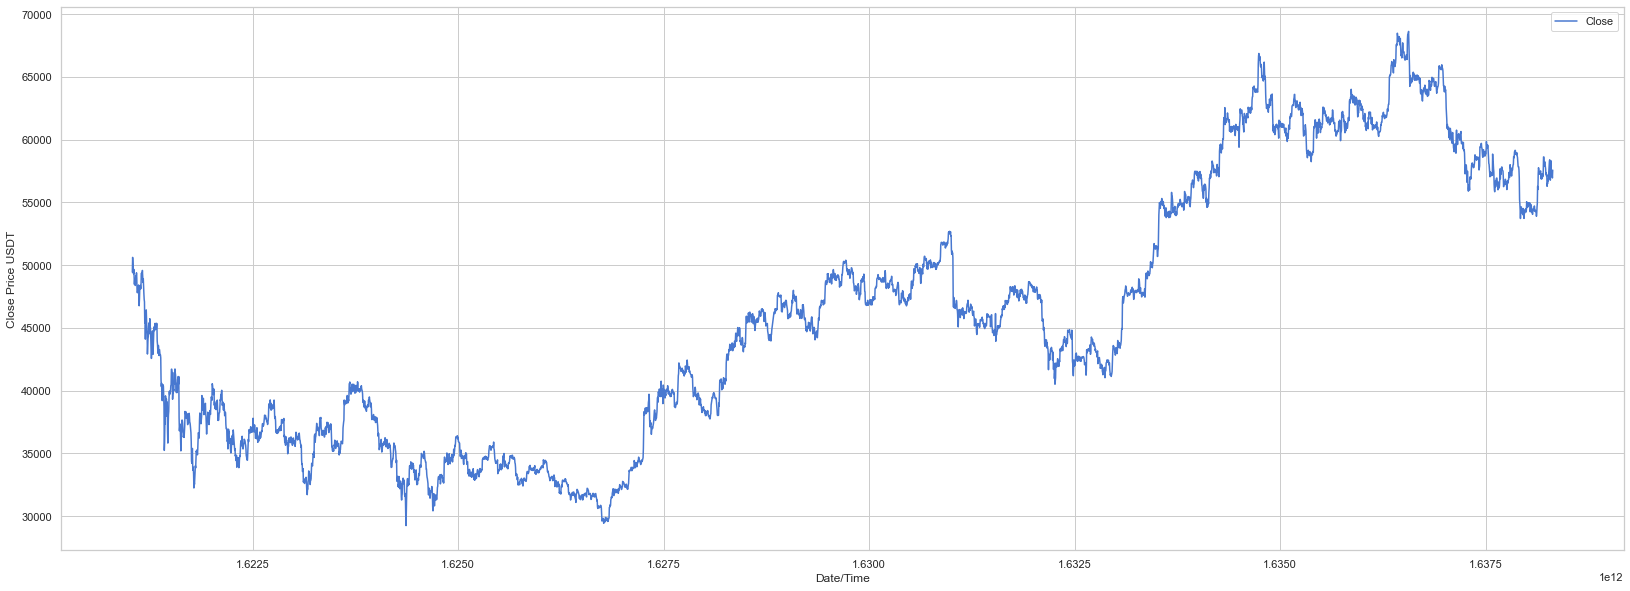

In [27]:
#Plotting the price over time 
ax = hist_df.plot(x ="Open Time", y = "Close")
ax.set_xlabel("Date/Time")
ax.set_ylabel("Close Price USDT")

Normalization of fetched data + verification that structures is maintained since hist_df 

In [28]:
scaler = MinMaxScaler()
close_price = hist_df.Close.values.reshape(-1,1)
scaled_close = scaler.fit_transform(close_price)

scaled_close.shape

(4795, 1)

In [29]:
#Checking if any shitty NaN values
np.isnan(scaled_close).any()

False

In [30]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1,1)

In [31]:
np.isnan(scaled_close).any()

False

Preprocessing of our scaled data 

In [32]:
SEQ_LEN = 100

def sequentization(data, seq_len):
    d = []
    
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)

def preprocessing(data_raw, seq_len, train_split):
    data = sequentization(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])

    x_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    x_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return x_train, y_train, x_test, y_test
x_train, y_train, x_test, y_test = preprocessing(scaled_close, SEQ_LEN, train_split = 0.95)

In [33]:
#Verify shapes of training & testing sets
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4460, 99, 1), (4460, 1), (235, 99, 1), (235, 1))

Creating our LSTM model 

In [36]:
# from tensorflow.python.keras.layers import CuDNNLSTM : Every time I try running this CuDNNLSTM I face all kind of issues

In [43]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences = True), 
                        input_shape = (WINDOW_SIZE, x_train.shape[-1])))
model.add(Dropout(rate = DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences = True)))
model.add(Dropout(rate = DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences = False)))
model.add(Dense(units=1))
model.add(Activation('linear'))


Model Training

In [44]:
model.compile(
    loss = "mean_squared_error",
    optimizer = "adam"
)

In [46]:
BATCH_SIZE = 64
history = model.fit(
    x_train,
    y_train,
    epochs = 10,
    batch_size = BATCH_SIZE,
    shuffle = False,
    validation_split = 0.1
)

Epoch 1/10
63/63 [==============================] - 142s 2s/step - loss: 0.0024 - val_loss: 0.0016
Epoch 2/10
63/63 [==============================] - 132s 2s/step - loss: 0.0051 - val_loss: 0.0033
Epoch 3/10
63/63 [==============================] - 135s 2s/step - loss: 0.0116 - val_loss: 0.0304
Epoch 4/10
63/63 [==============================] - 120s 2s/step - loss: 0.0090 - val_loss: 0.0058
Epoch 5/10
63/63 [==============================] - 121s 2s/step - loss: 0.0101 - val_loss: 0.0095
Epoch 6/10
63/63 [==============================] - 119s 2s/step - loss: 0.0151 - val_loss: 0.0222
Epoch 7/10
63/63 [==============================] - 133s 2s/step - loss: 0.0157 - val_loss: 0.0282
Epoch 8/10
63/63 [==============================] - 125s 2s/step - loss: 0.0116 - val_loss: 0.0138
Epoch 9/10
63/63 [==============================] - 125s 2s/step - loss: 0.0032 - val_loss: 4.9018e-04
Epoch 10/10
63/63 [==============================] - 144s 2s/step - loss: 4.7945e-04 - val_loss: 6.2781e-

In [49]:
# # Score model
# score = model.evaluate(validation_x, validation_y, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
# # Save model
# model.save("models/{}".format(NAME))

NameError: name 'validation_x' is not defined

In [ ]:
# #Saving our model 

# model.save(
#     r'C:\Users\Fluffy\Desktop\Bootcamp\Module 6\Crypto_EDA_LSTM_Prediction_FridayHaks',
#     overwrite=True,
#     include_optimizer=True,
#     save_format=None,
#     signatures=None,
#     options=None,
#     save_traces=True,
# )

# # Score model
# score = model.evaluate(validation_x, validation_y, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
# # Save model
# model.save("models/{}".format(NAME))

In [47]:
model.evaluate(x_test, y_test)

8/8 [==============================] - 2s 213ms/step - loss: 0.0018


0.0017647389322519302

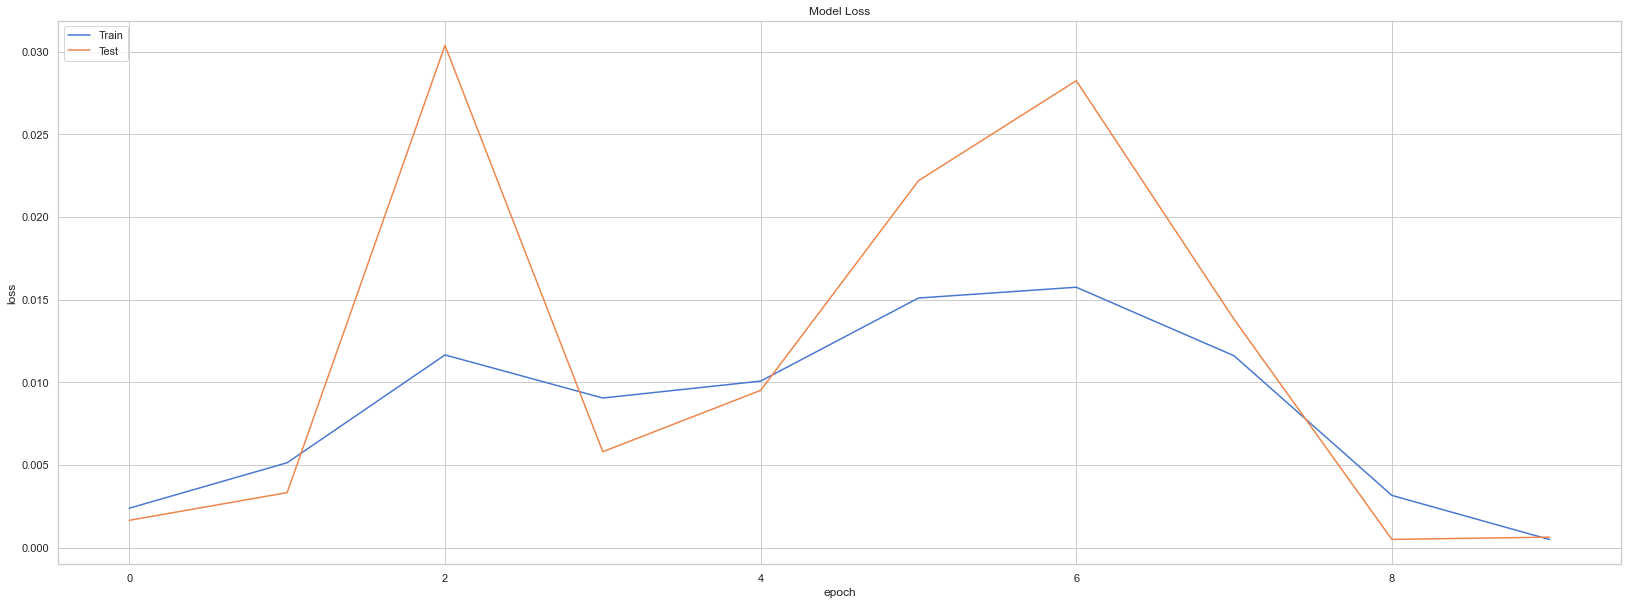

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

Prediction

In [52]:
rcParams['figure.figsize'] = 20, 10


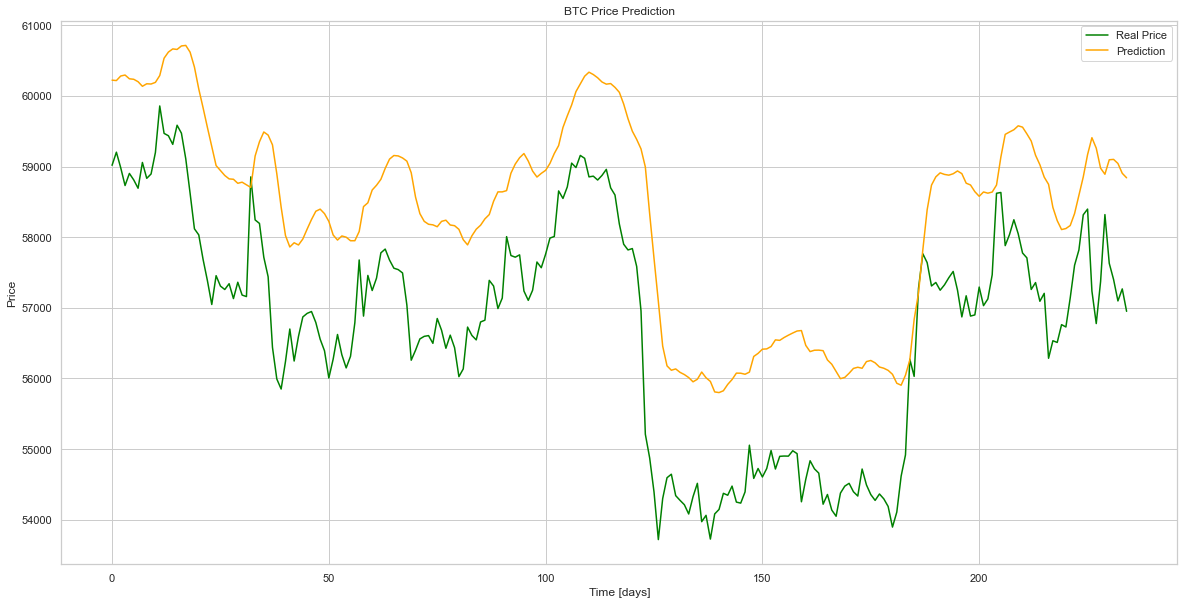

In [53]:
y_pred = model.predict(x_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

plt.plot(y_test_inverse, label = "Real Price", color = "green")
plt.plot(y_pred_inverse, label = "Prediction", color = "orange")
plt.title('BTC Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc = 'best')
plt.show()

Generating Real Prediction
If using 1hr model, we fetch Last Week 1h candles Data 

In [ ]:
#Immediate prediction
